In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import swifter
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv('../data/train.csv.zip').dropna()
test_df = pd.read_csv('../data/test.csv.zip').dropna()
train_df.head()

/home/omid-dev/Personal/venvs/data_science_challenges/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
corpus = pd.concat([train_df.question1, train_df.question2])

tfidf_vect = TfidfVectorizer().fit(corpus)

In [14]:
def calculate_cosine_similarity(question1, question2):
    q1_vector = tfidf_vect.transform([question1])
    q2_vector = tfidf_vect.transform([question2])
    return cosine_similarity(q1_vector, q2_vector).ravel()[0]

train_df['csim'] = train_df.swifter.apply(lambda x: calculate_cosine_similarity(x['question1'], x['question2']), axis=1)
train_df.head()

Dask Apply: 100%|██████████| 32/32 [02:07<00:00,  3.99s/it]


,id,qid1,qid2,question1,question2,is_duplicate,csim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.978515
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.749755
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.254677
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.260064


In [20]:
# find the best threshold to use by trying all thresholds and getting their accuracies
def is_correct(row, ratio_type, threshold):
    is_duplicate = True if row['is_duplicate'] == 1 else False
    return is_duplicate == (row[ratio_type] >= threshold)

thres_accuracy_map = {}

for threshold in range(0, 100, 5):
    csim_col = f'csim_correct_{threshold}'
    train_df[csim_col] = train_df.swifter.apply(lambda x: is_correct(x, 'csim', threshold/100), axis=1)
    csim_accuracy = len(train_df[csim_col].loc[train_df[csim_col] == True])/len(train_df[csim_col])

    thres_accuracy_map[threshold] = {
        'csim_accuracy': csim_accuracy,
    }
thres_accuracy_map

Dask Apply: 100%|██████████| 32/32 [00:01<00:00, 22.70it/s]


{0: {'csim_accuracy': 0.3692005926482919},
 5: {'csim_accuracy': 0.4624313915609456},
 10: {'csim_accuracy': 0.47893946627024864},
 15: {'csim_accuracy': 0.49968462997820856},
 20: {'csim_accuracy': 0.5276078627311785},
 25: {'csim_accuracy': 0.559018716901607},
 30: {'csim_accuracy': 0.5895119061458816},
 35: {'csim_accuracy': 0.6170542213823348},
 40: {'csim_accuracy': 0.6392166950705811},
 45: {'csim_accuracy': 0.6545968581725359},
 50: {'csim_accuracy': 0.6631155589964555},
 55: {'csim_accuracy': 0.6664597179726284},
 60: {'csim_accuracy': 0.6644462968138971},
 65: {'csim_accuracy': 0.6603501967661587},
 70: {'csim_accuracy': 0.6555986217711676},
 75: {'csim_accuracy': 0.6536965076789508},
 80: {'csim_accuracy': 0.6544632896927183},
 85: {'csim_accuracy': 0.6583615105110974},
 90: {'csim_accuracy': 0.6574240576620074},
 95: {'csim_accuracy': 0.6480668436036776}}

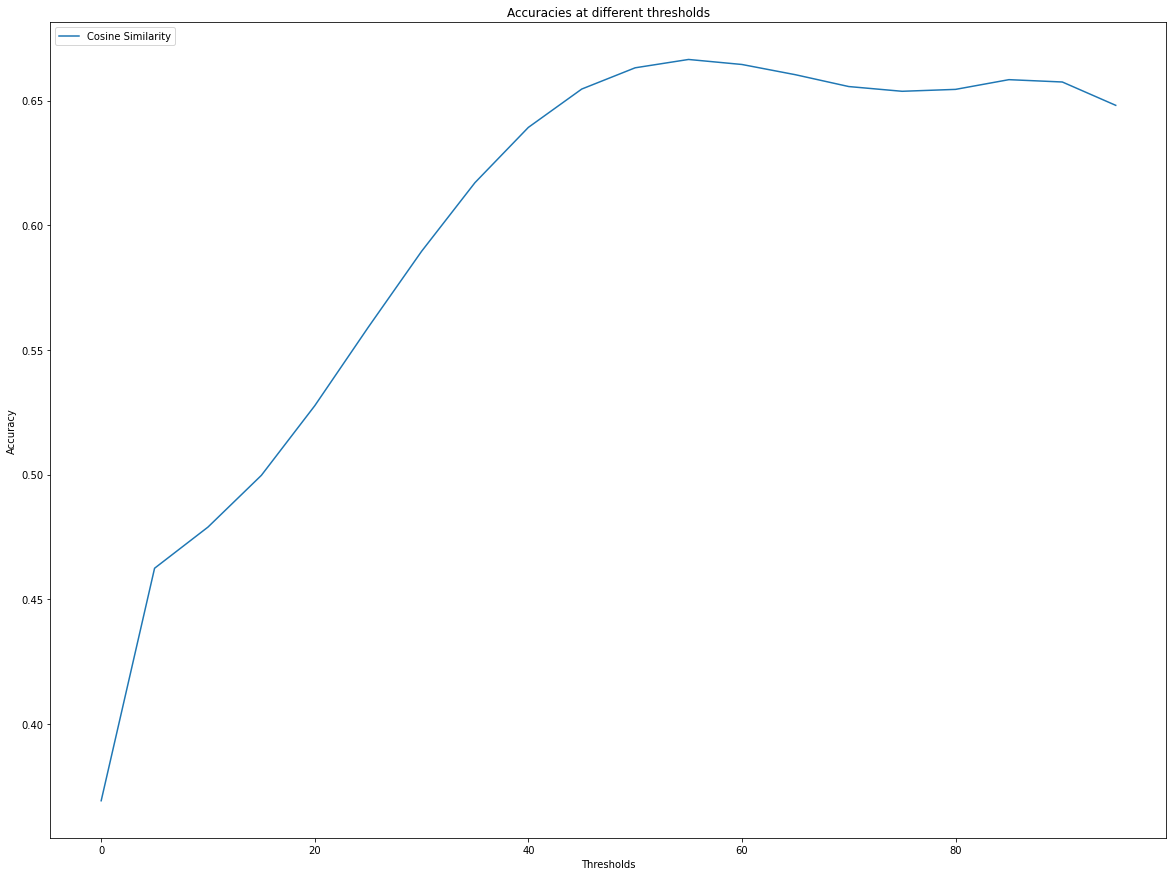

In [23]:
plt.figure(num=1, figsize=(20,15))

plt.plot(thres_accuracy_map.keys(), [accuracies['csim_accuracy'] for accuracies in thres_accuracy_map.values()], label='Cosine Similarity')

plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.title("Accuracies at different thresholds")
plt.legend(loc="upper left")

In [25]:
false_negatives = train_df.loc[train_df['csim_correct_55'] == False]
false_negatives.to_csv('../output/csim_correct_55_false_negatives.csv')
false_negatives.count()

id                 134846
qid1               134846
qid2               134846
question1          134846
question2          134846
is_duplicate       134846
csim               134846
csim_correct_0     134846
csim_correct_5     134846
csim_correct_10    134846
csim_correct_15    134846
csim_correct_20    134846
csim_correct_25    134846
csim_correct_30    134846
csim_correct_35    134846
csim_correct_40    134846
csim_correct_45    134846
csim_correct_50    134846
csim_correct_55    134846
csim_correct_60    134846
csim_correct_65    134846
csim_correct_70    134846
csim_correct_75    134846
csim_correct_80    134846
csim_correct_85    134846
csim_correct_90    134846
csim_correct_95    134846
dtype: int64

Conclusion
- Same problems as v1_base, using cosine similarity gives an almost identical accuracy at the same best threshold of 55.
- Need to create a model that accounts that looks at the meaning of the text.